In [17]:
import os
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from scipy.optimize import minimize

In [2]:
data_path = os.path.join(os.getcwd(), "final_rawcounts_merged.csv")
print(data_path)

/Users/gautam/Downloads/KU_Leuven_Bioinformatics_Masters/datathon_ambulance/final_rawcounts_merged.csv


In [55]:
# Read data
data = pd.read_csv(data_path)
#data = data.iloc[:, 1:8]
#data = data.iloc[:, data.columns != 'municipality']
# data['y'] = data['DOA_cardiac_count'] / data['population']
#data['DOA_all_count'] = data['DOA_all_count'] / data['population']
#data['aed_count'] = data['aed_count'] / data['population']
#data['cardiac_intervention_count'] = data['cardiac_intervention_count'] / data['interventions_count']
#data['interventions_count'] = data['interventions_count'] / data['population']
#data['DOA_cardiac_count'] = data['DOA_cardiac_count'] / data['population']

#X = data.drop(columns = ['postal_code', 'DOA_cardiac'])
#y = data['DOA_cardiac']
X = data.iloc[:, [2, 3, 5, 6, 7, 8]]
y = data.iloc[:, 4]

In [56]:
# train-test split for model evaluation
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
 
# Standardizing data
scaler = MinMaxScaler()
scaler.fit(pd.DataFrame(X_train_raw['avg_intervention_time']))
X_train = copy.deepcopy(X_train_raw).drop(columns = 'avg_intervention_time')
X_train['avg_intervention_time'] = scaler.transform(pd.DataFrame(X_train_raw['avg_intervention_time']))
X_test = copy.deepcopy(X_test_raw).drop(columns = 'avg_intervention_time')
X_test['avg_intervention_time'] = scaler.transform(pd.DataFrame(X_test_raw['avg_intervention_time']))
# scaler2 = StandardScaler()
# scaler2.fit(pd.DataFrame(y_train_raw))
# y_train = scaler2.transform(pd.DataFrame(y_train_raw))
# y_test = scaler2.transform(pd.DataFrame(y_test_raw))

In [57]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
X_train = copy.deepcopy(X_train_raw)
X_test = copy.deepcopy(X_test_raw)

In [68]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(n_estimators = 1000, max_depth = 10)
clf.fit(X_train.to_numpy(), y_train.to_numpy())
pred = clf.predict(X_test)

/Users/gautam/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


60.846462600340374

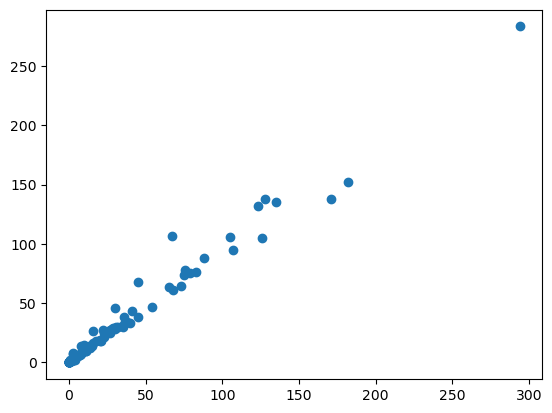

In [69]:
plt.scatter(y_test, pred)
np.mean((y_test.to_numpy() - pred)**2)

In [61]:
data_without_aed_counts = X.drop(columns = 'aed_count')
x0 = data['aed_count'].to_numpy()
total_aeds = np.sum(x0)

def objective(x):
    frame = data_without_aed_counts
    frame['aed_count'] = pd.Series(x)
    res = clf.predict(frame)
    res_norm = np.linalg.norm(res)
    return res_norm

def constraint1(x):
    return np.sum(x) - total_aeds



cons = {'type' : 'eq', 'fun' : constraint1}

res = minimize(objective, x0, constraints = cons, method = 'SLSQP')

/Users/gautam/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/gautam/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/gautam/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/gautam/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/gautam/miniconda3/envs/pytorch_env/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warni

In [62]:
table = pd.DataFrame(data['postal_code'])
table['aed_count'] = res.x

In [41]:
table.to_csv('randomforest_aed_pred.csv', sep=',')

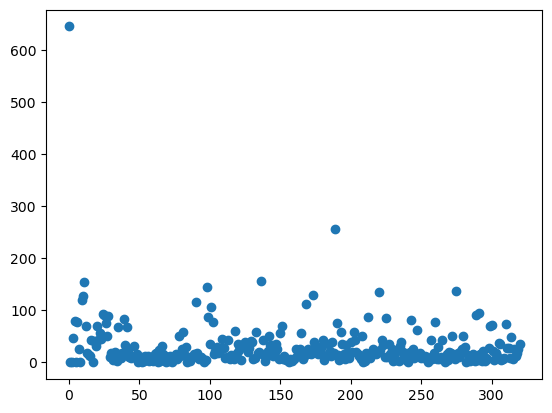

In [63]:
plt.scatter(range(len(res.x)), res.x)